In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}
'''
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap
'''

'\nfrom matplotlib.colors import LinearSegmentedColormap\n# Define the color map\ncolors = [\'#dadaeb\',\'#6a51a3\']\ncustom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)\ncmm=custom_cmap\n'

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
#sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
#sample2['binned_age'] = sample2['binned_age']+0.5
#df_male = pd.concat([sample,sample2])
df_male = sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [6]:
# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [7]:
# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [8]:
ba = m_df[syll_sort_m]

In [9]:
ind1 = 6
ind2 = 36
b1 = ba.loc[(ind1, "M1_01")].to_numpy().squeeze()
b2 = ba.loc[(ind1, "M1_02")].to_numpy().squeeze()

b3 = ba.loc[(ind2, "M1_01")].to_numpy().squeeze()
b4 = ba.loc[(ind2, "M1_02")].to_numpy().squeeze()

syll_df = pd.concat(
    [
        pd.DataFrame(
            dict(
                diff=b1 - b2,
                sort_diff=np.sort(b1 - b2),
                m1=b1,
                m2=b2,
                age=ind1,
                ord=np.arange(len(b1))[np.argsort(b1 - b2)],
            )
        ),
        pd.DataFrame(
            dict(
                diff=b3 - b4,
                sort_diff=np.sort(b3 - b4),
                m1=b3,
                m2=b4,
                age=ind2,
                ord=np.arange(len(b3))[np.argsort(b3 - b4)],
            )
        ),
    ]
).reset_index()
syll_df = syll_df.rename(columns={"index": "syllable"})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


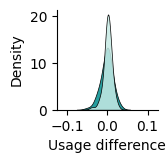

In [10]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
ax = sns.kdeplot(data=syll_df, x='diff', hue='age', bw_adjust=1.5, palette=cmm, fill=True, edgecolor='k', linewidth=0.5, alpha=0.85, legend=False)
ax.set(xlabel="Usage difference", xlim=(-0.125, 0.125))
sns.despine()

In [11]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'longv2_2indv_diff_dist.pdf')

In [12]:
idx = np.argsort(b2 + b4)[::-1]

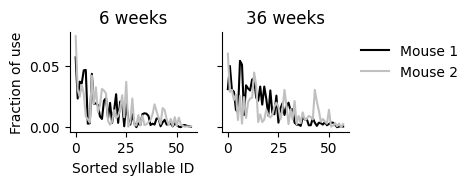

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(3.6, 1.3), sharey=True)
ax[0].plot(b2[idx], label="Mouse 1", c='k')
ax[0].plot(b1[idx], label="Mouse 2", c='silver')
ax[1].plot(b4[idx], label="Mouse 1", c='k')
ax[1].plot(b3[idx], label="Mouse 2", c='silver')
ax[1].set(title=f"{ind2} weeks")
ax[0].set(xlabel="Sorted syllable ID", ylabel="Fraction of use", title=f"{ind1} weeks")
legend(ax[1])
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'longv2_2indv_line.pdf')

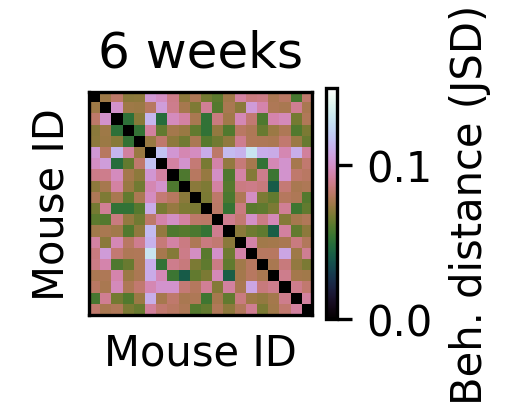

In [15]:
age = syll_df['age'].min()
out = squareform(pdist(ba.loc[ind1]))
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(out, vmax=0.15, cmap='cubehelix')
ax.set(xticks=[], yticks=[], xlabel="Mouse ID", ylabel="Mouse ID", title=f"{age} weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (JSD)")
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'longv2_2indv_dist_age1.pdf')

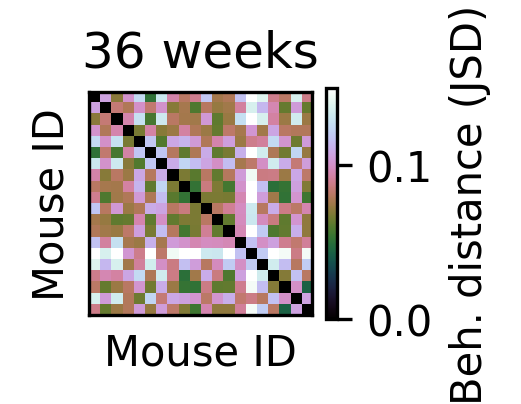

In [16]:
age = syll_df['age'].max()
out = squareform(pdist(ba.loc[ind2]))
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(out, vmax=0.15, cmap='cubehelix')
ax.set(xticks=[], yticks=[], xlabel="Mouse ID", ylabel="Mouse ID", title=f"{age} weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (JSD)")
fig.savefig(c.dana_save_path / "fig4"/ 'longv2_2indv_dist_age2.pdf')